# Result Exploration
This notebook helps to build functions for printing results of CNN training. 

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from IPython.display import display
from IPython.display import display_html

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Scripts import Print_Functions as PF
from Scripts import Centralized_Pain_CNN as painCNN
from Scripts import Data_Loader_Functions as DL

FIGURES = os.path.join(module_path, "Figures")
RESULTS = os.path.join(module_path, "Results")
DATA = os.path.join(module_path, "Data", "Augmented Data", "Flexible Augmentation")

## Prepare Plots for Aggregate Metrics

In [10]:
# Define variables
model_type = 'Federated'
data_type = 'Balanced'

centralized_path = os.path.join(module_path, 'Models', 'Pain', 'Centralized', 'Final', data_type)
centralized_model_paths = [os.path.join(centralized_path, path) for path in os.listdir(centralized_path) if 'shard-0.00' in path]
federated_path = os.path.join(module_path, 'Models', 'Pain', 'Federated', 'Final', data_type)
federated_model_paths = [os.path.join(federated_path, path) for path in os.listdir(federated_path) if 'shard-0.00' in path]
model_paths = centralized_model_paths if model_type == 'Centralized' else federated_model_paths

### Step 0: Create Baseline Metrics

In [11]:
# Load and prepare data
test_path = os.path.join(DATA, "group_2_test")
test_data, test_labels = DL.load_pain_data(test_path)
test_labels_binary = DL.reduce_pain_label_categories(test_labels[:, 4].astype(int), 1)
enc = OneHotEncoder(sparse=False, categories='auto')
test_labels_binary = enc.fit_transform(test_labels_binary.reshape(len(test_labels_binary), 1))
people = test_labels[:, 0].astype(int)

0 images processed
1000 images processed
2000 images processed
3000 images processed
4000 images processed
5000 images processed
6000 images processed
7000 images processed
8000 images processed
9000 images processed


In [12]:
# Load model
model = tf.keras.models.load_model(model_paths[0])

In [13]:
# Make predictions
loss = tf.keras.losses.BinaryCrossentropy()
df = painCNN.evaluate_pain_cnn(model, 0, test_data, test_labels_binary, history=None, people=None, loss=loss)
df['Shard'] = 0.00

In [14]:
# Save predictions to file
baseline_path = os.path.join(RESULTS, 'Final', data_type, '2019-08-01_PAIN_0-' + data_type.lower() + "-" + model_type + '-Baseline')
if not os.path.isdir(baseline_path):
    os.mkdir(baseline_path)

file = time.strftime("%Y-%m-%d-%H%M%S") + "_PAIN_" + data_type.lower() + "-" + model_type + ".csv"
df.to_csv(os.path.join(baseline_path, file))

### Step 1: Set parameters

In [98]:
# Set variable to plot
# current_metric = 'Accuracy'
# current_metric = 'Precision'
# current_metric = 'Recall'
# current_metric = 'F1_Score'
current_metric = 'Avg. Precision'

In [99]:
# Set experiment filter
criteria = '-balanced'

### Step 2: Get relevant folders

In [100]:
# Get all paths in Final Results folder
final_results = os.path.join(RESULTS, 'Final', data_type)
final_results_folders = sorted([os.path.join(final_results, path) for path in os.listdir(final_results)])

In [101]:
# Filter paths for relevant experiments
final_results_folders = [folder for folder in final_results_folders if criteria in folder]

### Step 3.1: Draw Aggregate plot

In [102]:
metric = 'Aggregate ' + current_metric

Text(0.5, 0, 'Epochs / Communication Rounds')

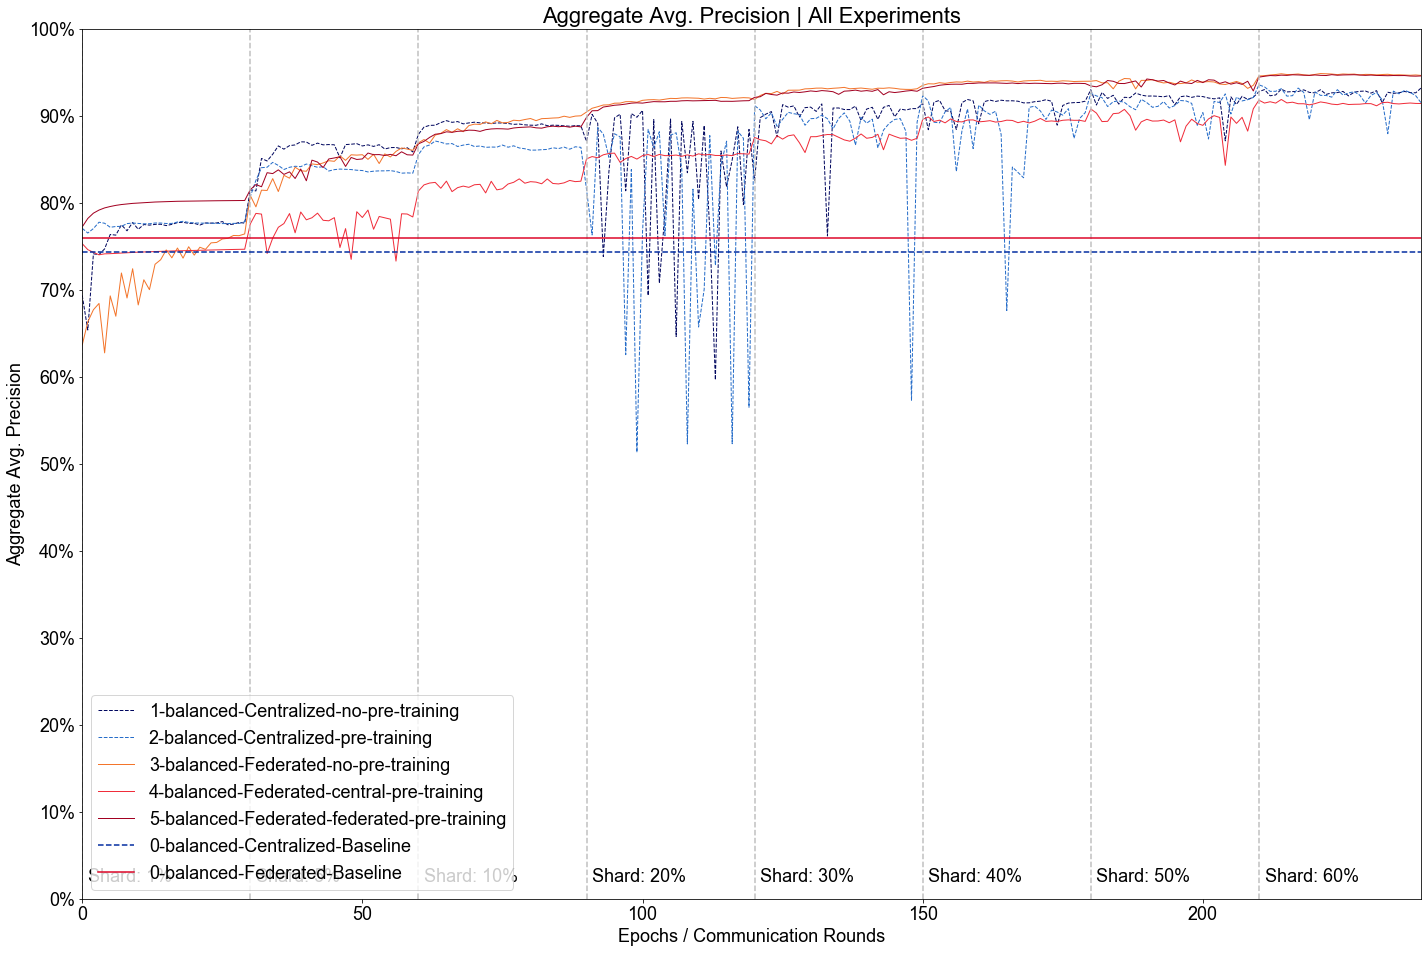

In [103]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 18, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 22})

# Draw Aggregate Plot
columns = ['Shard', 'Epoch', 'Loss', 'Aggregate Avg. Precision', 'Aggregate Accuracy', 
            'Aggregate Precision', 'Aggregate Recall', 'Aggregate F1_Score']

colors = ['#00065E', '#266DC9', '#F3752B', '#F02D3A', '#A20021']
line_style = ['--', '--', '-', '-', '-']

# Draw metrics
folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = pd.DataFrame(columns=columns)
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            df_concat = pd.concat((df_concat, df), ignore_index=True)
            df_concat.drop_duplicates(inplace=True)
    df_concat.reset_index(inplace=True)
    ax = df_concat[metric].plot(figsize=(24, 16), color=colors[idx], linewidth=1, linestyle=line_style[idx])

# Draw VLines
for i, file in enumerate(sorted(os.listdir(folders[0]))):
    ax.axvline(i * (df_concat['Epoch'].max() + 1), color='#C0C0C0', linestyle='dashed', label='_nolegend_')
    plt.text(i * (df_concat['Epoch'].max() + 1) + 1, 0.02, "Shard: {:.0%}".format(float(file.split('_shard-')[1].split('_')[0])))

# Draw Baselines
baseline_folders = sorted([folder for folder in final_results_folders if 'Baseline' in folder])
h_colors =['#002BA0', '#DD0426']
h_line_style = ['--', '-']
for idx, folder in enumerate(baseline_folders):
    for file in os.listdir(folder):
        file = os.path.join(folder, file)
        df = pd.read_csv(file, index_col=0)
        ax.axhline(df[metric].iloc[0], color=h_colors[idx], linestyle=h_line_style[idx])


# Set plot parameters
folders.extend(baseline_folders)
ax.legend([folder.split('PAIN_')[1] for folder in folders], loc='best')
ax.set_title("{} | All Experiments".format(metric))
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_yticklabels(['{:,.0%}'.format(x) for x in np.arange(0,1.1,0.1)])
ax.set_ylabel(metric)
ax.set_xlabel('Epochs / Communication Rounds')

In [104]:
# Save figure
fig_path = os.path.join(FIGURES, 'Final', data_type)
file = os.path.join(fig_path, metric + '.png')
fig = ax.get_figure()
fig.savefig(file, dpi=300)

### Step 3.2 Individual Standard Deviation

In [105]:
# Specify Metrics
current_metric = "F1-Score" if current_metric == "F1_Score" else current_metric
metric = 'Individual ' + current_metric

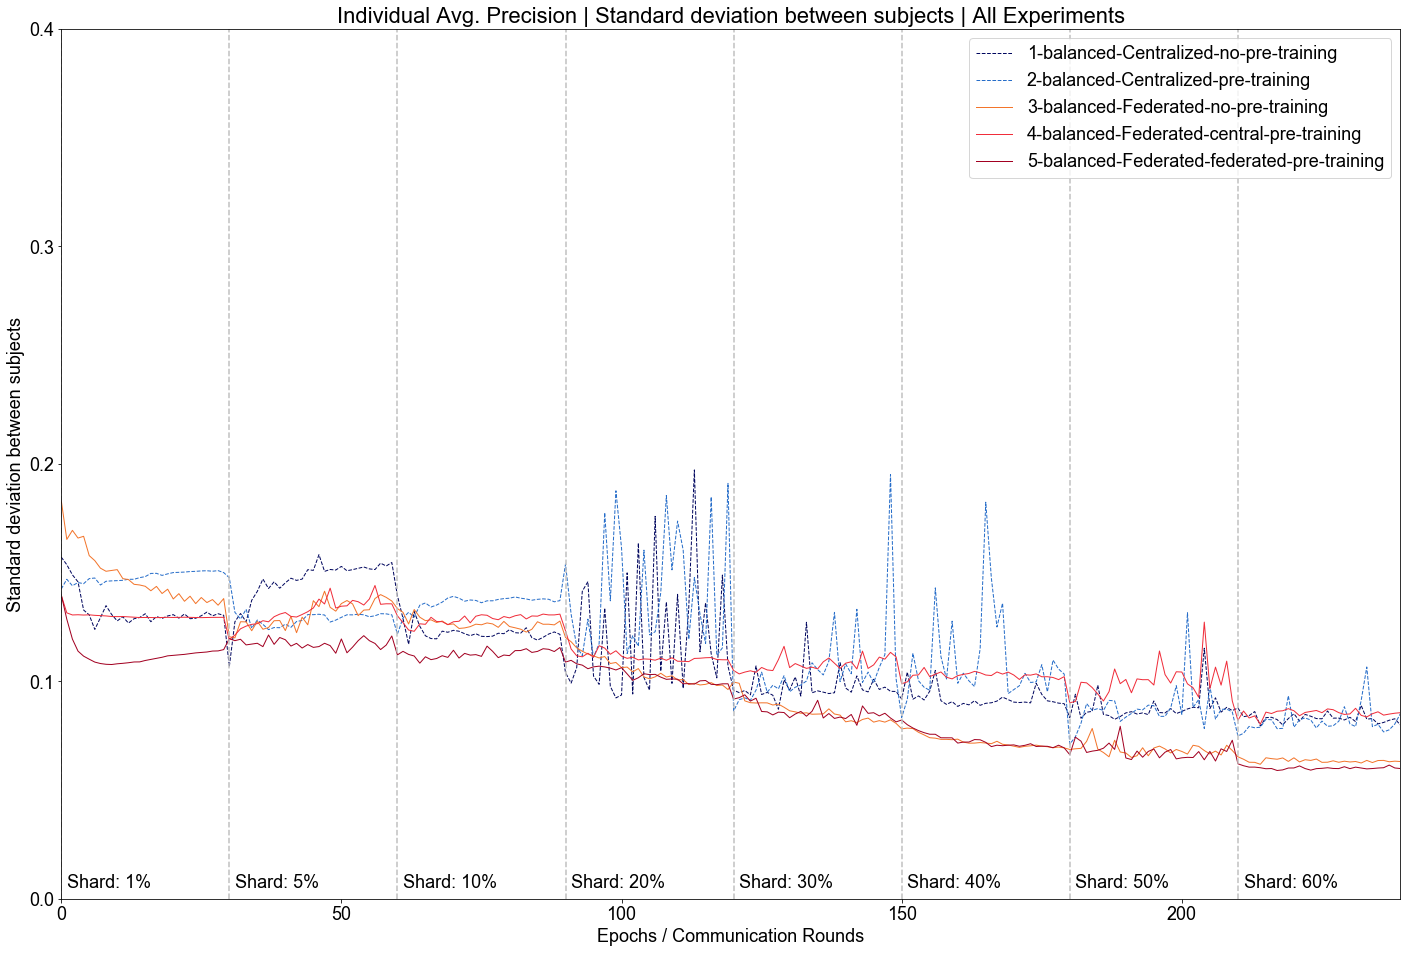

In [106]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 18, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 22})

# Draw standard deviation
columns = ['Shard', 'Epoch', 'Person', 'Loss', 'Individual Avg. Precision', 'Individual Accuracy', 
            'Individual Precision', 'Individual Recall', 'Individual F1-Score']

colors = ['#00065E', '#266DC9', '#F3752B', '#F02D3A', '#A20021']
line_style = ['--', '--', '-', '-', '-']

# Plot standard deviations
folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = None
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            df['Person'] = df['Person'].astype(int)
            pivot = df.pivot(index='Epoch', columns='Person', values=metric)
            if df_concat is None:
                df_concat = pd.DataFrame(columns=pivot.columns)
            df_concat = pd.concat((df_concat, pivot), ignore_index=True)
    df_concat['Mean'] = df_concat.mean(axis=1)
    df_concat['SD'] = df_concat.std(axis=1)
    ax = df_concat['SD'].plot(figsize=(24, 16), color=colors[idx], linewidth=1, linestyle=line_style[idx])
    
for i, file in enumerate(sorted(os.listdir(folders[0]))):
    ax.axvline(i * int(len(df_concat) / len(os.listdir(folders[0]))), color='#C0C0C0', linestyle='dashed', label='_nolegend_')
    plt.text(i * int(len(df_concat) / len(os.listdir(folders[0]))) + 1, 0.005, "Shard: {:.0%}".format(float(file.split('_shard-')[1].split('_')[0])))
    
ax.legend([folder.split('PAIN_')[1] for folder in folders], loc='best')
ax.set_title("{} | Standard deviation between subjects | All Experiments".format(metric))
ax.set_yticks(np.arange(0, 0.5, 0.1))
ax.set_ylabel('Standard deviation between subjects')
ax.set_xlabel('Epochs / Communication Rounds')
metric = 'SD_' + metric

In [107]:
# Save figure
fig_path = os.path.join(FIGURES, 'Final', data_type)
file = os.path.join(fig_path, metric + '.png')
fig = ax.get_figure()
fig.savefig(file, dpi=300)

### Step 3.3 Individual metrics

In [108]:
# Specify Metrics
current_metric = "F1-Score" if current_metric == "F1_Score" else current_metric
metric = 'Individual ' + current_metric

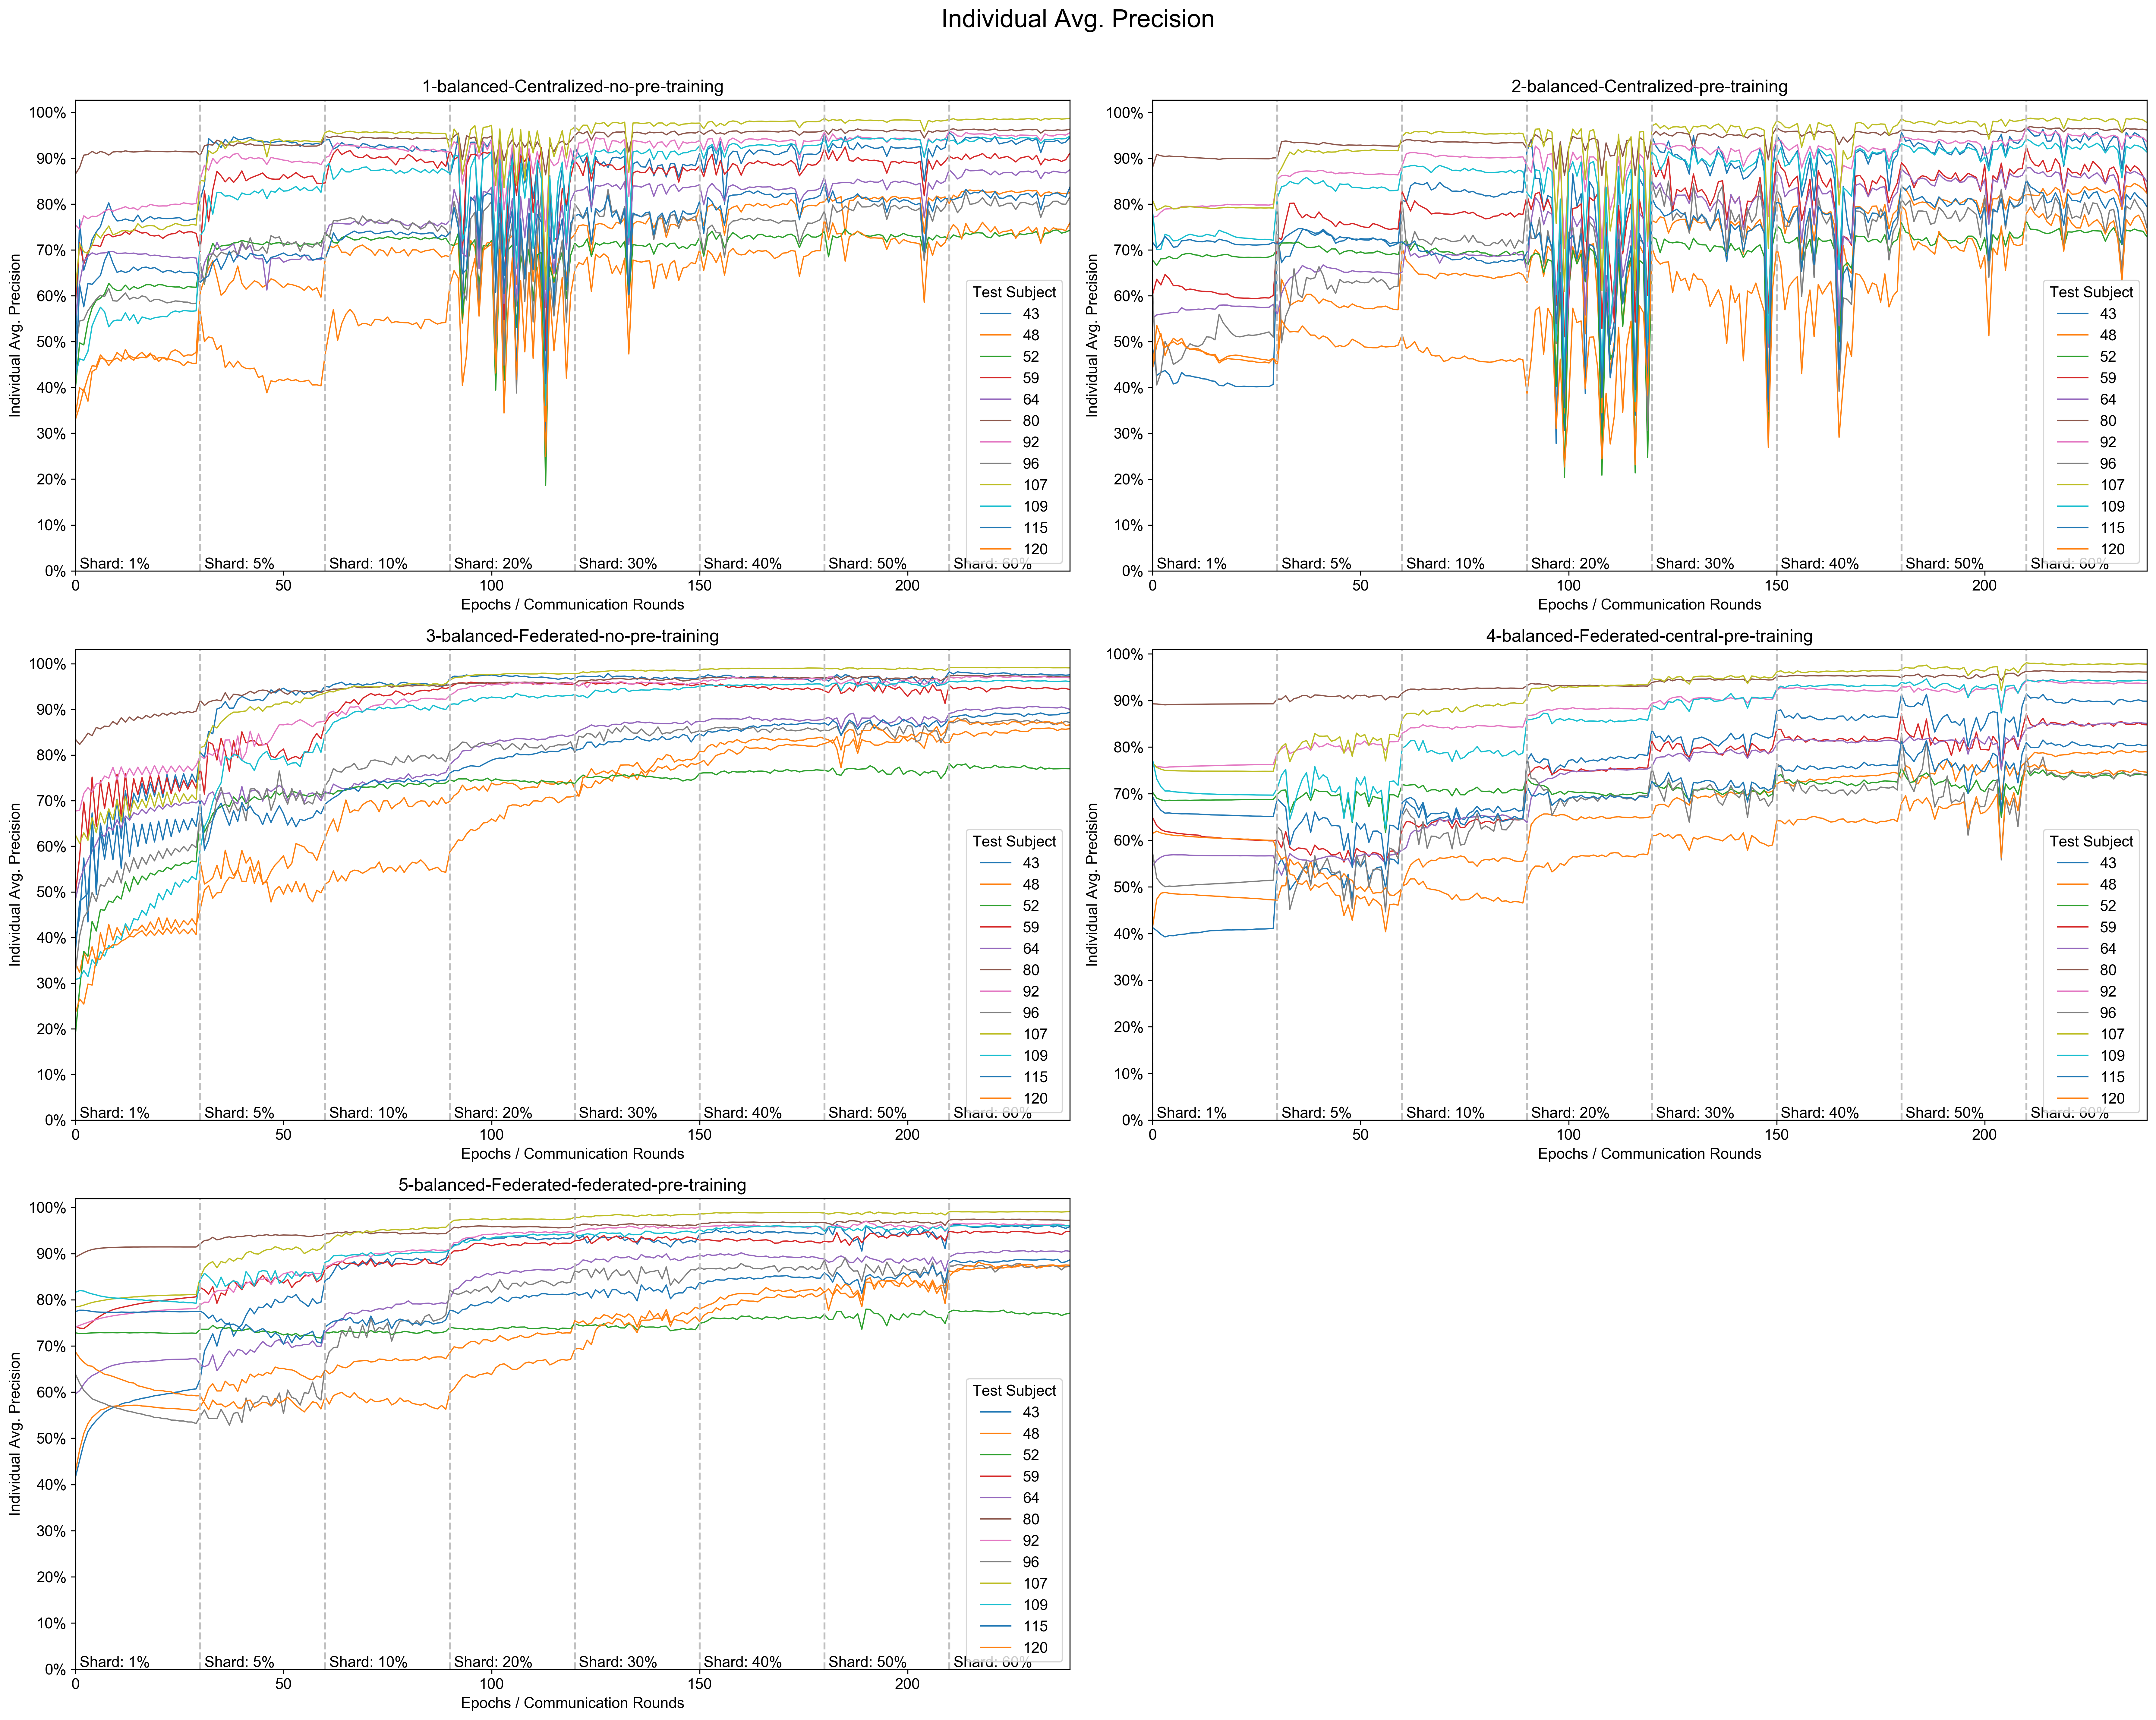

In [109]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 12, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 14})

# Draw individual metrics
columns = ['Shard', 'Epoch', 'Person', 'Loss', 'Individual Avg. Precision', 'Individual Accuracy', 
            'Individual Precision', 'Individual Recall', 'Individual F1-Score']

colors = ['#00065E', '#266DC9', '#F3752B', '#F02D3A', '#A20021']
line_style = ['--', '--', '-', '-', '-']

# Plot standard deviations
fig = plt.figure(dpi=300, figsize=(48, 60))
folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = None
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            df['Person'] = df['Person'].astype(int)
            pivot = df.pivot(index='Epoch', columns='Person', values=metric)
            if df_concat is None:
                df_concat = pd.DataFrame(columns=pivot.columns)
            df_concat = pd.concat((df_concat, pivot), ignore_index=True)
    ax = df_concat.plot(figsize=(24, 20), linewidth=1, ax=fig.add_subplot(3, 2, idx+1))
    
    for i, file in enumerate(sorted(os.listdir(folders[0]))):
        ax.axvline(i * int(len(df_concat) / len(os.listdir(folders[0]))), color='#C0C0C0', linestyle='dashed', label='_nolegend_')
        plt.text(i * int(len(df_concat) / len(os.listdir(folders[0]))) + 1, 0.005, "Shard: {:.0%}".format(float(file.split('_shard-')[1].split('_')[0])))
    
    ax.legend(loc='best', title='Test Subject')
    ax.set_title("{}".format(folder.split('PAIN_')[1]))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in np.arange(0,1.1,0.1)])
    ax.set_ylabel(metric)
    ax.set_xlabel('Epochs / Communication Rounds')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(metric, fontsize=20)
plt.show()

In [110]:
# Save figure
fig_path = os.path.join(FIGURES, 'Final', data_type)
file = os.path.join(fig_path, metric + '.png')
fig = ax.get_figure()
fig.savefig(file, dpi=300)

### Step 3.4 Individual Metrics - Final Epoch

In [111]:
# Specify Metrics
current_metric = "F1-Score" if current_metric == "F1_Score" else current_metric
metric = 'Individual ' + current_metric

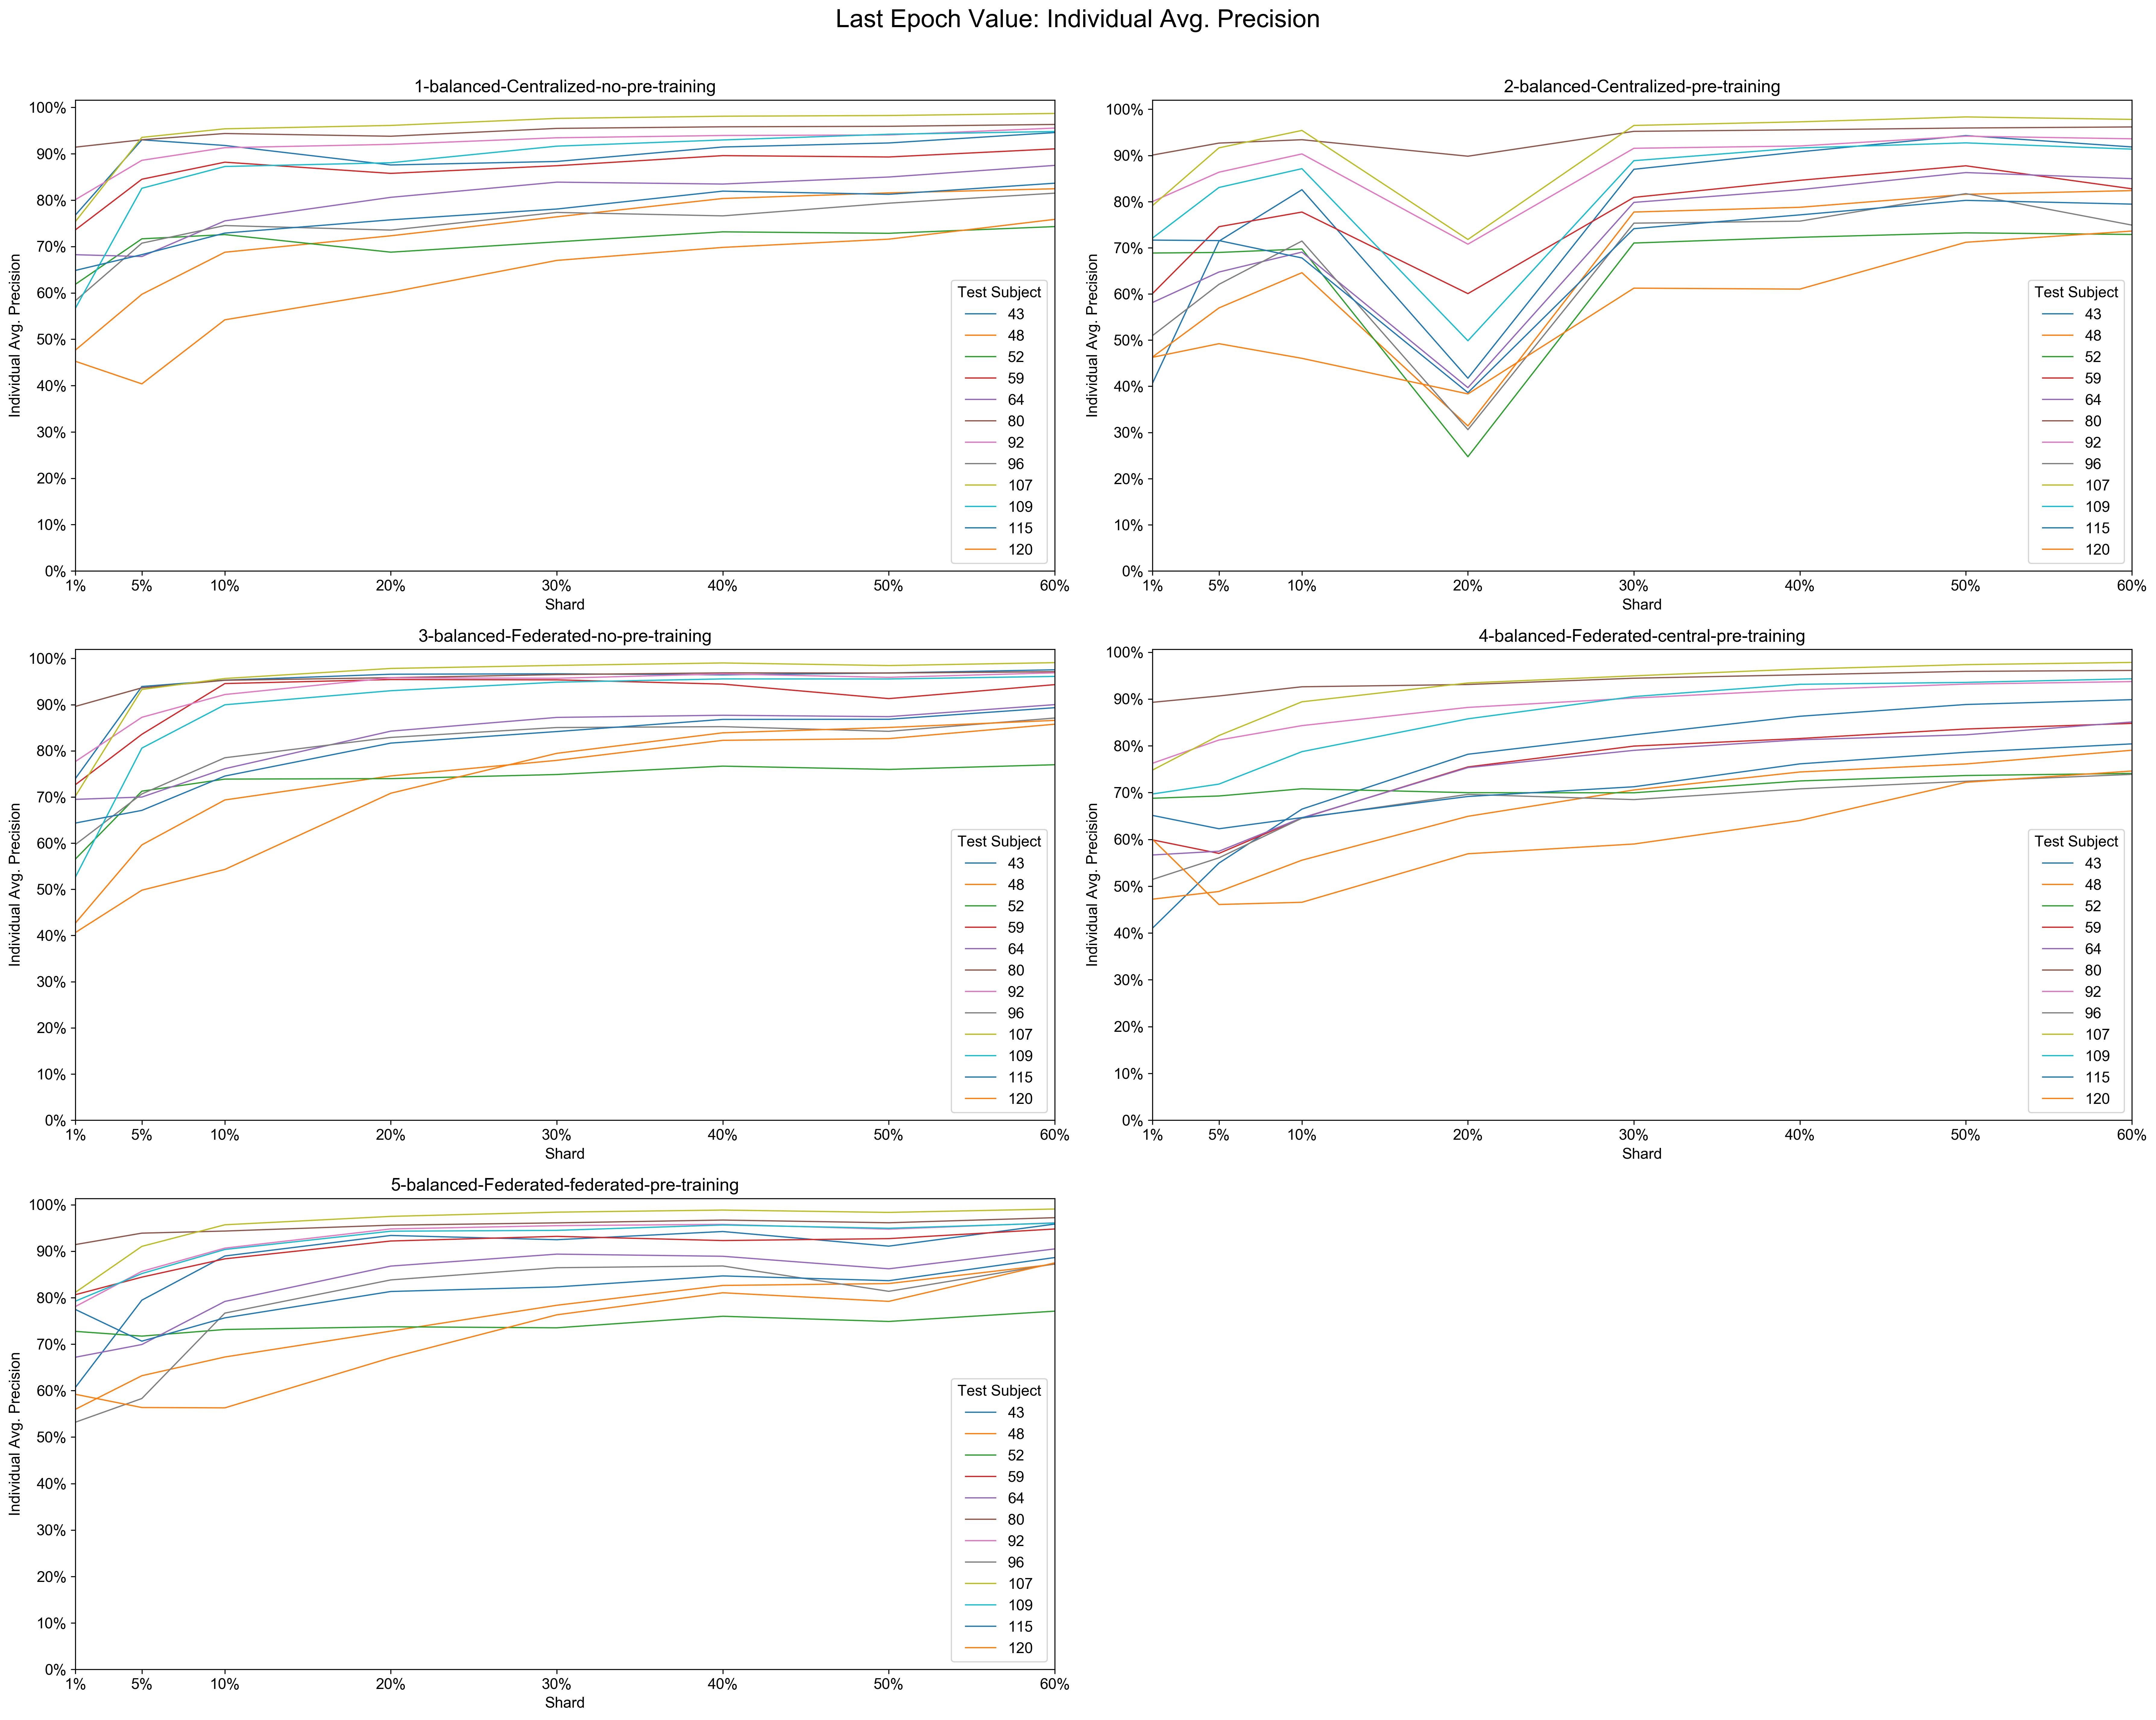

In [112]:
# Set PLT Parameters
plt.rcParams.update({'font.size': 12, 
                     'font.family' : 'arial', 
                     'font.weight' : 'normal',
                     'axes.titlesize' : 14})

# Draw individual metrics
columns = ['Shard', 'Epoch', 'Person', 'Loss', 'Individual Avg. Precision', 'Individual Accuracy', 
            'Individual Precision', 'Individual Recall', 'Individual F1-Score']

colors = ['#00065E', '#266DC9', '#F3752B', '#F02D3A', '#A20021']
line_style = ['--', '--', '-', '-', '-']

# Plot standard deviations
fig = plt.figure(dpi=300, figsize=(48, 60))
folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = None
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df = df[columns]
            df['Person'] = df['Person'].astype(int)
            df = df[df['Epoch'] == df['Epoch'].max()]
            if df_concat is None:
                df_concat = pd.DataFrame(columns=df.columns)
            df_concat = pd.concat((df_concat, df), ignore_index=True)
    pivot = df_concat.pivot(index='Shard', columns='Person', values=metric)
    ax = pivot.plot(figsize=(24, 20), linewidth=1, ax=fig.add_subplot(3, 2, idx+1))
    ax.legend(loc='best', title='Test Subject')
    ax.set_title("{}".format(folder.split('PAIN_')[1]))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in np.arange(0,1.1,0.1)])
    ax.set_ylabel(metric)
    ax.set_xticks(pivot.index)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in pivot.index])
    ax.set_xlabel('Shard')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Last Epoch Value: " + metric, fontsize=20)
plt.show()

In [113]:
# Save figure
fig_path = os.path.join(FIGURES, 'Final', data_type)
file = os.path.join(fig_path, "Last Epoch " + metric + '.png')
fig = ax.get_figure()
fig.savefig(file, dpi=300)

## Step 4: Sumarize data

In [114]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.render()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [115]:
# Display Data in Dataframe
metrics = ['Individual Accuracy', 'Individual Precision', 'Individual Recall', 'Individual F1-Score']
display_type = 'single'

folders = [folder for folder in final_results_folders if 'Baseline' not in folder]
for idx, folder in enumerate(folders):
    df_concat = None
    pivots = []
    print("\n\n\033[1m{}\033[0m".format(folder.split('PAIN_')[1]))
    for file in sorted(os.listdir(folder)):
        if 'shard-0.00' not in file:
            file = os.path.join(folder, file)
            df = pd.read_csv(file, index_col=0)
            df['Shard'] = float(file.split('_shard-')[1].split('_')[0])
            df['Person'] = df['Person'].astype(int)
            if df_concat is None:
                df_concat = pd.DataFrame(columns=df.columns)
            df_concat = pd.concat((df_concat, df), ignore_index=True)
            df_concat.drop_duplicates(inplace=True)
    df_concat.reset_index(inplace=True)
    for metric in metrics:
        columns = 'Shard'
        index = 'Person'
        df_filtered = df_concat[df_concat['Epoch'] == df_concat['Epoch'].max()]
        pivot = df_filtered[[index, columns, metric]].drop_duplicates().pivot(index=index, columns=columns, values=metric)
        cm = sns.diverging_palette(10, 130, n=9, as_cmap=True)
        style = pivot.style.background_gradient(cmap=cm).format('{:,.0%}').set_caption(metric)
        pivots.append(style)
    display_side_by_side(pivots[0], pivots[1])
    display_side_by_side(pivots[2], pivots[3])



1-balanced-Centralized-no-pre-training


Individual Accuracy Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 83% 
 88% 
 89% 
 89% 
 88% 
 89% 
 91% 
 92% 
 
 
 48 
 55% 
 74% 
 78% 
 78% 
 79% 
 81% 
 83% 
 83% 
 
 
 52 
 84% 
 88% 
 88% 
 86% 
 87% 
 88% 
 88% 
 88% 
 
 
 59 
 62% 
 76% 
 81% 
 76% 
 80% 
 79% 
 82% 
 83% 
 
 
 64 
 67% 
 70% 
 73% 
 76% 
 80% 
 79% 
 81% 
 81% 
 
 
 80 
 77% 
 81% 
 86% 
 83% 
 86% 
 86% 
 87% 
 88% 
 
 
 92 
 71% 
 81% 
 84% 
 82% 
 84% 
 87% 
 88% 
 89% 
 
 
 96 
 73% 
 77% 
 79% 
 79% 
 81% 
 80% 
 82% 
 83% 
 
 
 107 
 67% 
 82% 
 87% 
 87% 
 89% 
 91% 
 93% 
 93% 
 
 
 109 
 65% 
 81% 
 83% 
 86% 
 87% 
 90% 
 91% 
 91% 
 
 
 115 
 68% 
 73% 
 77% 
 77% 
 79% 
 81% 
 81% 
 84% 
 
 
 120 
 74% 
 77% 
 82% 
 82% 
 85% 
 85% 
 86% 
 86% 
 
 Individual Precision Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 74% 
 93% 
 90% 
 89% 
 91% 
 88% 
 92% 
 92% 
 
 
 48 
 41% 
 70% 
 74% 
 71% 
 71% 
 75% 
 79% 
 75% 
 
 
 52 
 65% 
 73% 
 72% 
 67% 
 71% 
 73% 
 71% 
 68% 
 
 
 59 
 59% 
 73% 
 77% 
 70% 
 75% 
 74% 
 78% 
 78% 
 
 
 64 
 58% 
 70% 
 72% 
 75% 
 80% 
 76% 
 79% 
 75% 
 
 
 80 
 86% 
 89% 
 90% 
 90% 
 91% 
 91% 
 91% 
 90% 
 
 
 92 
 72% 
 85% 
 85% 
 85% 
 87% 
 87% 
 89% 
 88% 
 
 
 96 
 59% 
 69% 
 73% 
 75% 
 74% 
 71% 
 74% 
 73% 
 
 
 107 
 69% 
 90% 
 91% 
 92% 
 94% 
 95% 
 95% 
 92% 
 
 
 109 
 52% 
 76% 
 84% 
 85% 
 86% 
 88% 
 89% 
 86% 
 
 
 115 
 54% 
 66% 
 76% 
 72% 
 76% 
 76% 
 78% 
 80% 
 
 
 120 
 42% 
 47% 
 59% 
 61% 
 66% 
 66% 
 71% 
 68%

Individual Recall Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 66% 
 65% 
 71% 
 71% 
 67% 
 72% 
 76% 
 83% 
 
 
 48 
 78% 
 41% 
 58% 
 60% 
 66% 
 67% 
 69% 
 74% 
 
 
 52 
 50% 
 65% 
 65% 
 65% 
 64% 
 68% 
 69% 
 73% 
 
 
 59 
 81% 
 82% 
 91% 
 94% 
 93% 
 91% 
 92% 
 94% 
 
 
 64 
 68% 
 46% 
 55% 
 62% 
 66% 
 71% 
 72% 
 81% 
 
 
 80 
 87% 
 89% 
 94% 
 91% 
 93% 
 94% 
 94% 
 97% 
 
 
 92 
 97% 
 89% 
 93% 
 90% 
 91% 
 95% 
 94% 
 99% 
 
 
 96 
 58% 
 55% 
 59% 
 55% 
 65% 
 70% 
 68% 
 77% 
 
 
 107 
 85% 
 79% 
 87% 
 85% 
 89% 
 90% 
 93% 
 96% 
 
 
 109 
 51% 
 73% 
 67% 
 74% 
 79% 
 84% 
 86% 
 91% 
 
 
 115 
 60% 
 52% 
 49% 
 57% 
 61% 
 70% 
 63% 
 74% 
 
 
 120 
 52% 
 35% 
 48% 
 51% 
 57% 
 60% 
 60% 
 68% 
 
 Individual F1-Score Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 70% 
 77% 
 79% 
 79% 
 77% 
 79% 
 83% 
 87% 
 
 
 48 
 54% 
 52% 
 65% 
 65% 
 68% 
 71% 
 74% 
 75% 
 
 
 52 
 57% 
 69% 
 68% 
 66% 
 68% 
 70% 
 70% 
 71% 
 
 
 59 
 69% 
 77% 
 83% 
 80% 
 83% 
 82% 
 84% 
 85% 
 
 
 64 
 63% 
 55% 
 63% 
 68% 
 72% 
 73% 
 76% 
 78% 
 
 
 80 
 87% 
 89% 
 92% 
 91% 
 92% 
 92% 
 93% 
 93% 
 
 
 92 
 83% 
 87% 
 89% 
 87% 
 89% 
 91% 
 92% 
 93% 
 
 
 96 
 58% 
 61% 
 65% 
 64% 
 69% 
 70% 
 71% 
 75% 
 
 
 107 
 76% 
 84% 
 89% 
 89% 
 91% 
 92% 
 94% 
 94% 
 
 
 109 
 51% 
 74% 
 75% 
 79% 
 82% 
 86% 
 87% 
 88% 
 
 
 115 
 57% 
 58% 
 60% 
 64% 
 68% 
 73% 
 70% 
 77% 
 
 
 120 
 46% 
 40% 
 53% 
 55% 
 61% 
 63% 
 65% 
 68%



2-balanced-Centralized-pre-training


Individual Accuracy Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 69% 
 77% 
 85% 
 57% 
 87% 
 89% 
 92% 
 90% 
 
 
 48 
 66% 
 67% 
 73% 
 46% 
 78% 
 80% 
 82% 
 83% 
 
 
 52 
 88% 
 86% 
 87% 
 32% 
 87% 
 88% 
 88% 
 88% 
 
 
 59 
 53% 
 65% 
 72% 
 61% 
 75% 
 78% 
 80% 
 78% 
 
 
 64 
 64% 
 68% 
 70% 
 47% 
 79% 
 79% 
 82% 
 81% 
 
 
 80 
 75% 
 81% 
 82% 
 60% 
 83% 
 86% 
 87% 
 87% 
 
 
 92 
 68% 
 75% 
 76% 
 68% 
 82% 
 84% 
 87% 
 86% 
 
 
 96 
 68% 
 73% 
 78% 
 48% 
 79% 
 79% 
 82% 
 80% 
 
 
 107 
 60% 
 79% 
 86% 
 55% 
 90% 
 90% 
 92% 
 91% 
 
 
 109 
 73% 
 80% 
 83% 
 41% 
 86% 
 88% 
 90% 
 88% 
 
 
 115 
 76% 
 74% 
 74% 
 39% 
 78% 
 79% 
 81% 
 80% 
 
 
 120 
 81% 
 81% 
 79% 
 64% 
 83% 
 83% 
 85% 
 87% 
 
 Individual Precision Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 50% 
 63% 
 87% 
 40% 
 86% 
 90% 
 92% 
 90% 
 
 
 48 
 52% 
 52% 
 61% 
 34% 
 69% 
 74% 
 75% 
 78% 
 
 
 52 
 80% 
 67% 
 66% 
 21% 
 67% 
 72% 
 69% 
 70% 
 
 
 59 
 54% 
 61% 
 68% 
 60% 
 71% 
 74% 
 73% 
 75% 
 
 
 64 
 55% 
 60% 
 63% 
 43% 
 78% 
 77% 
 78% 
 80% 
 
 
 80 
 87% 
 89% 
 89% 
 88% 
 90% 
 91% 
 90% 
 91% 
 
 
 92 
 75% 
 76% 
 79% 
 71% 
 86% 
 87% 
 87% 
 89% 
 
 
 96 
 74% 
 69% 
 73% 
 32% 
 71% 
 71% 
 72% 
 74% 
 
 
 107 
 75% 
 84% 
 90% 
 72% 
 91% 
 93% 
 93% 
 92% 
 
 
 109 
 84% 
 78% 
 86% 
 37% 
 84% 
 87% 
 86% 
 82% 
 
 
 115 
 71% 
 64% 
 65% 
 33% 
 72% 
 72% 
 73% 
 76% 
 
 
 120 
 71% 
 59% 
 53% 
 29% 
 65% 
 65% 
 68% 
 75%

Individual Recall Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 19% 
 63% 
 60% 
 81% 
 69% 
 71% 
 80% 
 76% 
 
 
 48 
 22% 
 63% 
 62% 
 58% 
 68% 
 66% 
 72% 
 71% 
 
 
 52 
 53% 
 64% 
 69% 
 82% 
 68% 
 66% 
 73% 
 74% 
 
 
 59 
 55% 
 86% 
 83% 
 69% 
 84% 
 89% 
 94% 
 85% 
 
 
 64 
 70% 
 64% 
 60% 
 87% 
 66% 
 69% 
 78% 
 68% 
 
 
 80 
 83% 
 89% 
 90% 
 62% 
 91% 
 93% 
 96% 
 94% 
 
 
 92 
 81% 
 94% 
 90% 
 91% 
 90% 
 90% 
 96% 
 92% 
 
 
 96 
 8% 
 34% 
 56% 
 50% 
 62% 
 62% 
 77% 
 61% 
 
 
 107 
 52% 
 81% 
 87% 
 43% 
 92% 
 91% 
 94% 
 94% 
 
 
 109 
 33% 
 62% 
 66% 
 84% 
 76% 
 79% 
 86% 
 85% 
 
 
 115 
 53% 
 62% 
 56% 
 73% 
 63% 
 66% 
 71% 
 65% 
 
 
 120 
 18% 
 33% 
 27% 
 46% 
 42% 
 50% 
 60% 
 57% 
 
 Individual F1-Score Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 28% 
 63% 
 71% 
 53% 
 76% 
 79% 
 86% 
 83% 
 
 
 48 
 31% 
 57% 
 62% 
 43% 
 68% 
 70% 
 73% 
 74% 
 
 
 52 
 63% 
 66% 
 68% 
 33% 
 68% 
 69% 
 71% 
 72% 
 
 
 59 
 54% 
 72% 
 75% 
 64% 
 77% 
 81% 
 82% 
 80% 
 
 
 64 
 61% 
 62% 
 62% 
 57% 
 71% 
 73% 
 78% 
 74% 
 
 
 80 
 85% 
 89% 
 90% 
 73% 
 90% 
 92% 
 93% 
 92% 
 
 
 92 
 78% 
 84% 
 84% 
 80% 
 88% 
 89% 
 91% 
 90% 
 
 
 96 
 14% 
 46% 
 63% 
 39% 
 67% 
 66% 
 74% 
 67% 
 
 
 107 
 62% 
 83% 
 88% 
 54% 
 92% 
 92% 
 94% 
 93% 
 
 
 109 
 47% 
 69% 
 75% 
 51% 
 79% 
 83% 
 86% 
 84% 
 
 
 115 
 61% 
 63% 
 60% 
 46% 
 67% 
 69% 
 72% 
 70% 
 
 
 120 
 28% 
 42% 
 35% 
 36% 
 51% 
 57% 
 64% 
 65%



3-balanced-Federated-no-pre-training


Individual Accuracy Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 71% 
 90% 
 92% 
 93% 
 93% 
 93% 
 93% 
 94% 
 
 
 48 
 36% 
 40% 
 79% 
 80% 
 81% 
 83% 
 82% 
 86% 
 
 
 52 
 75% 
 75% 
 88% 
 88% 
 88% 
 89% 
 85% 
 89% 
 
 
 59 
 50% 
 61% 
 85% 
 83% 
 86% 
 86% 
 85% 
 87% 
 
 
 64 
 52% 
 60% 
 75% 
 81% 
 82% 
 83% 
 81% 
 85% 
 
 
 80 
 86% 
 86% 
 87% 
 88% 
 88% 
 89% 
 89% 
 90% 
 
 
 92 
 70% 
 71% 
 86% 
 88% 
 88% 
 92% 
 85% 
 92% 
 
 
 96 
 67% 
 69% 
 83% 
 85% 
 86% 
 86% 
 85% 
 87% 
 
 
 107 
 63% 
 66% 
 88% 
 90% 
 92% 
 94% 
 89% 
 95% 
 
 
 109 
 61% 
 77% 
 84% 
 90% 
 90% 
 91% 
 92% 
 93% 
 
 
 115 
 53% 
 61% 
 77% 
 81% 
 81% 
 84% 
 84% 
 86% 
 
 
 120 
 58% 
 66% 
 80% 
 86% 
 89% 
 90% 
 89% 
 90% 
 
 Individual Precision Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 52% 
 77% 
 89% 
 96% 
 96% 
 97% 
 88% 
 94% 
 
 
 48 
 35% 
 36% 
 75% 
 74% 
 74% 
 83% 
 69% 
 84% 
 
 
 52 
 42% 
 45% 
 74% 
 75% 
 73% 
 77% 
 60% 
 74% 
 
 
 59 
 51% 
 56% 
 79% 
 75% 
 80% 
 81% 
 78% 
 81% 
 
 
 64 
 45% 
 51% 
 76% 
 83% 
 85% 
 82% 
 72% 
 82% 
 
 
 80 
 86% 
 86% 
 89% 
 90% 
 91% 
 92% 
 90% 
 92% 
 
 
 92 
 70% 
 71% 
 86% 
 87% 
 87% 
 91% 
 83% 
 91% 
 
 
 96 
 51% 
 52% 
 81% 
 81% 
 84% 
 81% 
 74% 
 82% 
 
 
 107 
 63% 
 64% 
 93% 
 95% 
 95% 
 97% 
 87% 
 96% 
 
 
 109 
 48% 
 63% 
 88% 
 89% 
 89% 
 88% 
 85% 
 89% 
 
 
 115 
 42% 
 47% 
 76% 
 84% 
 82% 
 82% 
 76% 
 83% 
 
 
 120 
 29% 
 35% 
 55% 
 71% 
 80% 
 80% 
 75% 
 80%

Individual Recall Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 75% 
 94% 
 83% 
 79% 
 80% 
 79% 
 90% 
 85% 
 
 
 48 
 97% 
 90% 
 58% 
 64% 
 70% 
 63% 
 86% 
 72% 
 
 
 52 
 64% 
 86% 
 63% 
 65% 
 66% 
 68% 
 88% 
 69% 
 
 
 59 
 98% 
 100% 
 96% 
 98% 
 97% 
 97% 
 97% 
 96% 
 
 
 64 
 85% 
 83% 
 56% 
 65% 
 67% 
 75% 
 85% 
 81% 
 
 
 80 
 100% 
 99% 
 97% 
 97% 
 97% 
 96% 
 98% 
 97% 
 
 
 92 
 100% 
 100% 
 96% 
 97% 
 98% 
 98% 
 99% 
 98% 
 
 
 96 
 70% 
 86% 
 64% 
 73% 
 71% 
 78% 
 84% 
 79% 
 
 
 107 
 98% 
 100% 
 86% 
 88% 
 92% 
 93% 
 97% 
 95% 
 
 
 109 
 76% 
 90% 
 65% 
 82% 
 82% 
 87% 
 94% 
 92% 
 
 
 115 
 94% 
 77% 
 52% 
 58% 
 61% 
 71% 
 80% 
 78% 
 
 
 120 
 64% 
 63% 
 31% 
 56% 
 65% 
 69% 
 74% 
 69% 
 
 Individual F1-Score Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 62% 
 85% 
 86% 
 87% 
 87% 
 87% 
 89% 
 89% 
 
 
 48 
 51% 
 51% 
 65% 
 69% 
 72% 
 72% 
 76% 
 77% 
 
 
 52 
 51% 
 59% 
 68% 
 70% 
 69% 
 72% 
 71% 
 72% 
 
 
 59 
 67% 
 72% 
 86% 
 85% 
 88% 
 88% 
 87% 
 88% 
 
 
 64 
 59% 
 63% 
 64% 
 73% 
 75% 
 78% 
 78% 
 82% 
 
 
 80 
 92% 
 92% 
 93% 
 93% 
 93% 
 94% 
 94% 
 94% 
 
 
 92 
 82% 
 83% 
 90% 
 92% 
 92% 
 94% 
 90% 
 94% 
 
 
 96 
 59% 
 65% 
 72% 
 77% 
 77% 
 79% 
 78% 
 81% 
 
 
 107 
 76% 
 78% 
 89% 
 91% 
 93% 
 95% 
 92% 
 96% 
 
 
 109 
 59% 
 74% 
 75% 
 85% 
 86% 
 88% 
 89% 
 91% 
 
 
 115 
 59% 
 58% 
 62% 
 68% 
 70% 
 77% 
 78% 
 80% 
 
 
 120 
 39% 
 45% 
 39% 
 62% 
 72% 
 74% 
 74% 
 74%



4-balanced-Federated-central-pre-training


Individual Accuracy Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 70% 
 74% 
 77% 
 82% 
 83% 
 87% 
 88% 
 89% 
 
 
 48 
 67% 
 68% 
 72% 
 75% 
 78% 
 79% 
 80% 
 82% 
 
 
 52 
 86% 
 88% 
 88% 
 88% 
 88% 
 88% 
 87% 
 89% 
 
 
 59 
 53% 
 57% 
 63% 
 69% 
 70% 
 74% 
 76% 
 78% 
 
 
 64 
 64% 
 66% 
 71% 
 73% 
 76% 
 79% 
 78% 
 80% 
 
 
 80 
 60% 
 71% 
 78% 
 80% 
 81% 
 84% 
 87% 
 87% 
 
 
 92 
 55% 
 66% 
 75% 
 78% 
 78% 
 82% 
 84% 
 85% 
 
 
 96 
 68% 
 70% 
 75% 
 77% 
 77% 
 79% 
 78% 
 78% 
 
 
 107 
 51% 
 66% 
 77% 
 83% 
 85% 
 89% 
 89% 
 90% 
 
 
 109 
 68% 
 73% 
 80% 
 84% 
 88% 
 90% 
 90% 
 91% 
 
 
 115 
 72% 
 70% 
 73% 
 76% 
 76% 
 77% 
 78% 
 79% 
 
 
 120 
 82% 
 79% 
 78% 
 81% 
 81% 
 81% 
 84% 
 87% 
 
 Individual Precision Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 55% 
 71% 
 67% 
 76% 
 77% 
 86% 
 84% 
 86% 
 
 
 48 
 58% 
 55% 
 61% 
 64% 
 70% 
 72% 
 70% 
 77% 
 
 
 52 
 85% 
 82% 
 75% 
 73% 
 74% 
 72% 
 67% 
 72% 
 
 
 59 
 54% 
 57% 
 63% 
 66% 
 68% 
 71% 
 73% 
 74% 
 
 
 64 
 56% 
 62% 
 66% 
 70% 
 76% 
 76% 
 72% 
 77% 
 
 
 80 
 87% 
 88% 
 88% 
 89% 
 91% 
 90% 
 90% 
 91% 
 
 
 92 
 78% 
 79% 
 79% 
 80% 
 85% 
 84% 
 84% 
 86% 
 
 
 96 
 82% 
 67% 
 71% 
 69% 
 67% 
 69% 
 66% 
 68% 
 
 
 107 
 78% 
 81% 
 87% 
 89% 
 92% 
 92% 
 88% 
 92% 
 
 
 109 
 89% 
 86% 
 91% 
 85% 
 89% 
 89% 
 87% 
 88% 
 
 
 115 
 66% 
 62% 
 66% 
 68% 
 69% 
 70% 
 68% 
 72% 
 
 
 120 
 85% 
 56% 
 49% 
 59% 
 58% 
 58% 
 62% 
 75%

Individual Recall Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 8% 
 28% 
 47% 
 60% 
 65% 
 70% 
 75% 
 76% 
 
 
 48 
 10% 
 33% 
 52% 
 62% 
 62% 
 67% 
 72% 
 67% 
 
 
 52 
 40% 
 53% 
 61% 
 66% 
 64% 
 67% 
 73% 
 73% 
 
 
 59 
 55% 
 61% 
 69% 
 80% 
 77% 
 83% 
 83% 
 86% 
 
 
 64 
 50% 
 41% 
 55% 
 60% 
 61% 
 70% 
 73% 
 72% 
 
 
 80 
 63% 
 77% 
 86% 
 89% 
 87% 
 91% 
 96% 
 94% 
 
 
 92 
 49% 
 70% 
 88% 
 90% 
 84% 
 92% 
 96% 
 94% 
 
 
 96 
 7% 
 18% 
 40% 
 57% 
 58% 
 66% 
 69% 
 65% 
 
 
 107 
 28% 
 59% 
 74% 
 82% 
 83% 
 89% 
 95% 
 92% 
 
 
 109 
 14% 
 32% 
 49% 
 69% 
 77% 
 84% 
 87% 
 87% 
 
 
 115 
 41% 
 41% 
 48% 
 60% 
 57% 
 64% 
 69% 
 66% 
 
 
 120 
 18% 
 23% 
 33% 
 43% 
 41% 
 48% 
 63% 
 57% 
 
 Individual F1-Score Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 13% 
 41% 
 55% 
 67% 
 70% 
 77% 
 79% 
 80% 
 
 
 48 
 17% 
 42% 
 56% 
 63% 
 66% 
 69% 
 71% 
 72% 
 
 
 52 
 54% 
 64% 
 67% 
 69% 
 68% 
 70% 
 70% 
 73% 
 
 
 59 
 55% 
 59% 
 66% 
 72% 
 72% 
 77% 
 78% 
 80% 
 
 
 64 
 53% 
 49% 
 60% 
 65% 
 68% 
 72% 
 72% 
 74% 
 
 
 80 
 73% 
 82% 
 87% 
 89% 
 89% 
 91% 
 93% 
 92% 
 
 
 92 
 61% 
 75% 
 83% 
 85% 
 84% 
 88% 
 89% 
 90% 
 
 
 96 
 13% 
 28% 
 51% 
 63% 
 62% 
 68% 
 68% 
 66% 
 
 
 107 
 41% 
 68% 
 80% 
 85% 
 87% 
 91% 
 92% 
 92% 
 
 
 109 
 25% 
 46% 
 64% 
 76% 
 83% 
 86% 
 87% 
 88% 
 
 
 115 
 51% 
 49% 
 56% 
 63% 
 62% 
 67% 
 69% 
 69% 
 
 
 120 
 29% 
 32% 
 40% 
 50% 
 48% 
 53% 
 62% 
 65%



5-balanced-Federated-federated-pre-training


Individual Accuracy Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 72% 
 78% 
 87% 
 92% 
 91% 
 90% 
 87% 
 93% 
 
 
 48 
 70% 
 73% 
 77% 
 82% 
 83% 
 83% 
 80% 
 87% 
 
 
 52 
 88% 
 88% 
 88% 
 87% 
 88% 
 89% 
 88% 
 89% 
 
 
 59 
 70% 
 78% 
 80% 
 85% 
 85% 
 86% 
 86% 
 87% 
 
 
 64 
 71% 
 70% 
 77% 
 84% 
 86% 
 85% 
 78% 
 86% 
 
 
 80 
 69% 
 74% 
 85% 
 87% 
 88% 
 89% 
 86% 
 90% 
 
 
 92 
 65% 
 64% 
 79% 
 86% 
 87% 
 90% 
 77% 
 91% 
 
 
 96 
 67% 
 70% 
 80% 
 84% 
 86% 
 86% 
 81% 
 86% 
 
 
 107 
 51% 
 69% 
 87% 
 90% 
 92% 
 94% 
 92% 
 95% 
 
 
 109 
 73% 
 78% 
 87% 
 90% 
 91% 
 93% 
 90% 
 93% 
 
 
 115 
 76% 
 73% 
 76% 
 81% 
 82% 
 83% 
 80% 
 86% 
 
 
 120 
 80% 
 82% 
 82% 
 86% 
 90% 
 89% 
 87% 
 91% 
 
 Individual Precision Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 74% 
 86% 
 88% 
 95% 
 95% 
 93% 
 96% 
 94% 
 
 
 48 
 79% 
 80% 
 76% 
 79% 
 77% 
 80% 
 87% 
 86% 
 
 
 52 
 86% 
 86% 
 71% 
 70% 
 72% 
 78% 
 78% 
 76% 
 
 
 59 
 70% 
 82% 
 74% 
 79% 
 80% 
 82% 
 87% 
 81% 
 
 
 64 
 71% 
 75% 
 72% 
 85% 
 87% 
 85% 
 90% 
 84% 
 
 
 80 
 87% 
 91% 
 89% 
 90% 
 91% 
 92% 
 94% 
 92% 
 
 
 92 
 77% 
 85% 
 79% 
 85% 
 86% 
 90% 
 96% 
 91% 
 
 
 96 
 77% 
 76% 
 72% 
 78% 
 83% 
 81% 
 84% 
 79% 
 
 
 107 
 84% 
 91% 
 90% 
 92% 
 94% 
 97% 
 97% 
 97% 
 
 
 109 
 93% 
 92% 
 81% 
 89% 
 90% 
 91% 
 92% 
 89% 
 
 
 115 
 90% 
 84% 
 68% 
 78% 
 80% 
 81% 
 86% 
 82% 
 
 
 120 
 87% 
 80% 
 57% 
 68% 
 79% 
 80% 
 82% 
 83%

Individual Recall Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 12% 
 33% 
 68% 
 78% 
 74% 
 74% 
 60% 
 81% 
 
 
 48 
 16% 
 28% 
 49% 
 65% 
 74% 
 69% 
 50% 
 74% 
 
 
 52 
 49% 
 49% 
 69% 
 66% 
 68% 
 66% 
 56% 
 70% 
 
 
 59 
 73% 
 72% 
 91% 
 94% 
 95% 
 94% 
 85% 
 98% 
 
 
 64 
 50% 
 38% 
 72% 
 72% 
 76% 
 75% 
 53% 
 82% 
 
 
 80 
 76% 
 78% 
 95% 
 95% 
 96% 
 95% 
 90% 
 97% 
 
 
 92 
 72% 
 58% 
 96% 
 96% 
 97% 
 96% 
 70% 
 97% 
 
 
 96 
 3% 
 15% 
 64% 
 73% 
 72% 
 75% 
 53% 
 78% 
 
 
 107 
 24% 
 55% 
 89% 
 91% 
 92% 
 93% 
 89% 
 95% 
 
 
 109 
 28% 
 44% 
 86% 
 84% 
 84% 
 88% 
 81% 
 91% 
 
 
 115 
 36% 
 30% 
 63% 
 64% 
 66% 
 69% 
 51% 
 76% 
 
 
 120 
 10% 
 23% 
 60% 
 69% 
 71% 
 67% 
 54% 
 73% 
 
 Individual F1-Score Shard 0.01 0.05 0.1 0.2 0.3 0.4 0.5 0.6 Person 
 
 43 
 20% 
 48% 
 77% 
 85% 
 83% 
 83% 
 74% 
 87% 
 
 
 48 
 27% 
 42% 
 59% 
 71% 
 75% 
 74% 
 63% 
 80% 
 
 
 52 
 63% 
 62% 
 70% 
 68% 
 70% 
 72% 
 65% 
 73% 
 
 
 59 
 71% 
 77% 
 82% 
 86% 
 87% 
 87% 
 86% 
 89% 
 
 
 64 
 58% 
 50% 
 72% 
 78% 
 81% 
 80% 
 66% 
 83% 
 
 
 80 
 81% 
 84% 
 92% 
 93% 
 93% 
 94% 
 91% 
 94% 
 
 
 92 
 74% 
 69% 
 86% 
 90% 
 91% 
 93% 
 81% 
 94% 
 
 
 96 
 6% 
 25% 
 68% 
 76% 
 77% 
 78% 
 65% 
 78% 
 
 
 107 
 37% 
 68% 
 90% 
 91% 
 93% 
 95% 
 93% 
 96% 
 
 
 109 
 43% 
 59% 
 83% 
 86% 
 87% 
 90% 
 86% 
 90% 
 
 
 115 
 52% 
 44% 
 65% 
 70% 
 73% 
 75% 
 64% 
 79% 
 
 
 120 
 19% 
 35% 
 58% 
 69% 
 75% 
 73% 
 65% 
 78%